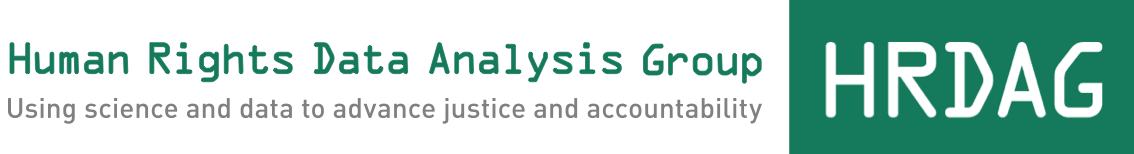

In [1]:
from IPython.display import Image
Image(filename='../imgs/banner.png')

In [2]:
%load_ext pretty_jupyter

In [3]:
%%jmd

Authors:
- Bailey Passmore, Data Scientist, [HRDAG](hrdag.org)
- Larry Barrett, Consultant, [HRDAG](hrdag.org)


Authors:
- Bailey Passmore, Data Scientist, [HRDAG](hrdag.org)
- Larry Barrett, Consultant, [HRDAG](hrdag.org)

In [4]:
import pendulum

In [5]:
%%jmd

{{ pendulum.now('America/Los_Angeles').strftime('%A, %d %B %Y at %I:%M %p (%Z)') }}


Tuesday, 11 March 2025 at 07:26 PM (PDT)

In [6]:
%%html

<style>
    #Styling {
        font-weight: bold;
        font-family: Helvetica;
    }
</style>

# Goal

- What we have in dev-pre-restructure is working fine but we're on a short deadline and need to streamline the data. Let's make a barebones table of the core data we need for analysis, including:
    - `event_no`
    - `date_occurred` (w/ `year_occurred`)
    - `source_type` (a field derived from the initial event type in the data, either 911 call reporting gunfire or Shotspotter GDT alert)
    - `event_location` (service address if specified)
    - `date_dispatched` (is this the same as date of arrival?)
    - `area` (the result of mapping the reported police district to the [police area](https://www.cbsnews.com/chicago/news/chicago-police-department-detective-areas-divisions-boundaries/))

# Research questions we're working towards

1. Is dispatch reported at the same rate for all districts?
2. RE: Soundthinking / Brookings Institute claim that some 80% of gunfire events do not get reported by citizens - is that True in Chicago?
    * When SST alerts aren't matched to 911 calls, what is the typical disposition of such an alert?
    * When 911 calls aren't matched to SST alert, what is the typical disposition?

# Time period covered

- Earliest date occurred included: '2021-01-01'
- Last date occurred included: '2024-09-23' (Per CPD, "ShotSpotter technology for the City of Chicago was discontinued in September 2024, meaning no records are available beyond that date.") The last date a ShotSpotter alert appears in the data is 23 September 2024, so we include records up to and including this date.

# Identifying Event type (based on the _init_type_ field)

```
shotspotter = ['SST', 'PSST', 'MSST'] # keywords provided by CPD in Info sheet
citizencalls = ['SHOTS', 'SHOTSF', 'PERSHO',] # Note: 'PERGUN', 'PERDOW','PERHLP', 'DOMBAT', etc. excluded
```

# Note about what humans can do that SST can't

In the OEMC data, in addition to reports originating as calls about shots fired ('SHOTSF') or persons being shot ('PERSHO'), we also see events with an initial label 'PERGUN' and final label referring to shots fired or someone shot. This tells us that not only do Chicagoans report gunfire in general, they may also report early warning signs of conflict involving firearms before any shots occur, giving first responders a head start to arrive on scene and provide potentially life-saving care.

In [7]:
# dependencies
import re
import numpy as np
from datetime import timedelta
import pandas as pd
import fuzzywuzzy as fuzz

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

In [8]:
# support methods
def format_count(v):
    return "{:,}".format(v)


def format_prop(prop, decn=1, asperc=True):
    if asperc: prop = prop*100
    return "{}%".format(round(prop, decn))


def report_fields(df, idcol, cols, fillna=False, headn=10):
    data = df[[idcol] + cols].drop_duplicates()
    if fillna:
        count = data[cols].fillna('None reported').value_counts().to_frame().reset_index()
        perc = data[cols].fillna('None reported').value_counts(normalize=True).to_frame().reset_index(
            ).rename(columns={'proportion': 'percent'})
    else:
        count = data[cols].value_counts().to_frame().reset_index()
        perc = data[cols].value_counts(normalize=True).to_frame().reset_index(
            ).rename(columns={'proportion': 'percent'})
    count['count'] = count['count'].apply(format_count)
    perc.percent = perc.percent.apply(format_prop)
    out = pd.merge(count, perc, on=cols)
    return out.head(headn)


def report_overtime(df, idcol, yearcol):
    yearly = df[[idcol, yearcol]].groupby(yearcol).nunique().reset_index()
    yearly[yearcol] = yearly[yearcol].astype(str)
    yearly = yearly.sort_values(yearcol)
    return yearly

In [9]:
# main
colorder = [
    'event_no',
    'date_occurred',
    'date_dispatched',
    'area',
    'location',
    'location_x',
    'location_y',
    'init_type',
    'init_type_desc',
    'fin_type',
    'fin_type_desc',
    'disposition',
    'source_type',
    'early_warning',
]
data = pd.read_parquet("../../merge/output/events.parquet").rename(columns={
    'event_type': 'source_type',
    'event_type_init': 'init_type_desc',
    'event_type_fin': 'fin_type_desc',})[colorder]
assert data.event_no.nunique() == data.shape[0]
data['year_occurred'] = data.date_occurred.dt.year

In [10]:
sst = data.loc[data.source_type == 'ShotSpotter alert']
calls = data.loc[data.source_type == 'Human reporting gunfire']

# Review data

In [11]:
%%jmd

<details open>
<summary>Sample emergency event record.</summary>

{{ data.sample().T.to_html() }}

</details>


<details open>
<summary>Sample emergency event record.</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>94306</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>event_no</th>
      <td>2109000161</td>
    </tr>
    <tr>
      <th>date_occurred</th>
      <td>2021-03-31 00:19:48</td>
    </tr>
    <tr>
      <th>date_dispatched</th>
      <td>NaT</td>
    </tr>
    <tr>
      <th>area</th>
      <td>5</td>
    </tr>
    <tr>
      <th>location</th>
      <td>32XX  N LARAMIE AV /51XX  W SCHOOL ST</td>
    </tr>
    <tr>
      <th>location_x</th>
      <td>41.940</td>
    </tr>
    <tr>
      <th>location_y</th>
      <td>-87.756</td>
    </tr>
    <tr>
      <th>init_type</th>
      <td>SHOTSF</td>
    </tr>
    <tr>
      <th>init_type_desc</th>
      <td>SHOTS FIRED</td>
    </tr>
    <tr>
      <th>fin_type</th>
      <td>SHOTSF</td>
    </tr>
    <tr>
      <th>fin_type_desc</th>
      <td>SHOTS FIRED</td>
    </tr>
    <tr>
      <th>disposition</th>
      <td>None</td>
    </tr>
    <tr>
      <th>source_type</th>
      <td>Human reporting gunfire</td>
    </tr>
    <tr>
      <th>early_warning</th>
      <td>False</td>
    </tr>
    <tr>
      <th>year_occurred</th>
      <td>2021</td>
    </tr>
  </tbody>
</table>

</details>

# Counts

In [12]:
%%jmd

### Overall

- There are {{format_count(data.shape[0])}} gunfire-related 911 calls and ShotSpotter alerts prepared for this analysis.
- The data cover a time period between {{ data.date_occurred.dt.date.min() }} and {{ data.date_occurred.dt.date.max() }}.

---


### Overall

- There are 385,448 gunfire-related 911 calls and ShotSpotter alerts prepared for this analysis.
- The data cover a time period between 2021-01-01 and 2024-09-22.

---

In [13]:
%%jmd

### Source types

- Frequency table:

{{ report_fields(df=data, idcol='event_no', cols=['source_type',]).to_html() }}


- Summary: Of the {{format_count(data.shape[0])}} emergency events included in the analysis,
    - {{format_count(calls.shape[0]) }} or {{
        format_prop(calls.shape[0]/data.shape[0]) }}
        were generated by a 911 call, and
    - {{format_count(sst.shape[0])}} or {{
        format_prop(sst.shape[0]/data.shape[0])}}
        were generated by a ShotSpotter alert.

---

#### Initial Event types

Presented are:
- the initial event type as reported by OEMC and CPD (`init_type`),
- the description of the initial type as found in the data (`init_type_desc`), and
- the type of source which reported the event (`source_type`).

{{ report_fields(df=data,
                 idcol='event_no', cols=['init_type', 'init_type_desc', 'source_type'],
                 headn=10).to_html() }}

---


### Source types

- Frequency table:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>source_type</th>
      <th>count</th>
      <th>percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Human reporting gunfire</td>
      <td>228,552</td>
      <td>59.3%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>ShotSpotter alert</td>
      <td>156,896</td>
      <td>40.7%</td>
    </tr>
  </tbody>
</table>


- Summary: Of the 385,448 emergency events included in the analysis,
    - 228,552 or 59.3%
        were generated by a 911 call, and
    - 156,896 or 40.7%
        were generated by a ShotSpotter alert.

---

#### Initial Event types

Presented are:
- the initial event type as reported by OEMC and CPD (`init_type`),
- the description of the initial type as found in the data (`init_type_desc`), and
- the type of source which reported the event (`source_type`).

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>init_type</th>
      <th>init_type_desc</th>
      <th>source_type</th>
      <th>count</th>
      <th>percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>SHOTSF</td>
      <td>SHOTS FIRED</td>
      <td>Human reporting gunfire</td>
      <td>183,961</td>
      <td>47.7%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>SST</td>
      <td>SHOT SPOTTER</td>
      <td>ShotSpotter alert</td>
      <td>113,790</td>
      <td>29.5%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>MSST</td>
      <td>Multiple Shot - ShotSpotter</td>
      <td>ShotSpotter alert</td>
      <td>38,855</td>
      <td>10.1%</td>
    </tr>
    <tr>
      <th>3</th>
      <td>PERSHO</td>
      <td>PERSON SHOT</td>
      <td>Human reporting gunfire</td>
      <td>31,567</td>
      <td>8.2%</td>
    </tr>
    <tr>
      <th>4</th>
      <td>SHOTS</td>
      <td>SHOTS FIRED (OV)</td>
      <td>Human reporting gunfire</td>
      <td>13,024</td>
      <td>3.4%</td>
    </tr>
    <tr>
      <th>5</th>
      <td>PSST</td>
      <td>Probable Shot - ShotSpotter</td>
      <td>ShotSpotter alert</td>
      <td>4,251</td>
      <td>1.1%</td>
    </tr>
  </tbody>
</table>

---

<Axes: title={'center': 'Emergency Events Observed Over Time'}, xlabel='Year Occurred', ylabel='Record count'>

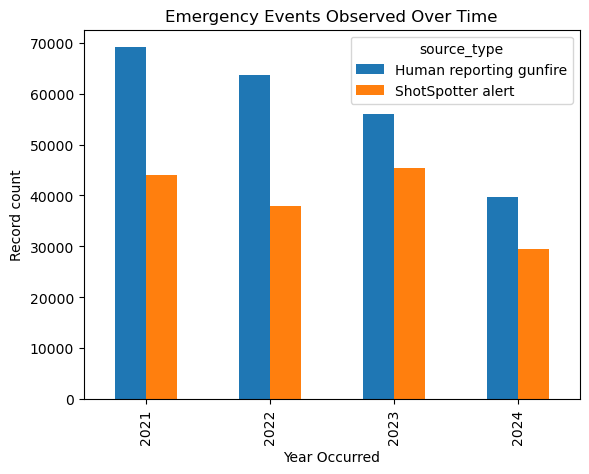

In [14]:
source_yearly = data[['event_no', 'year_occurred', 'source_type']
    ].groupby(['year_occurred', 'source_type']).nunique().reset_index()
src_ylr_piv = pd.pivot_table(
    source_yearly,
    values="event_no",
    index="year_occurred",
    columns="source_type",
    aggfunc="mean"
)
src_ylr_piv.plot(
    kind='bar',
    title='Emergency Events Observed Over Time',
    xlabel='Year Occurred', ylabel='Record count')

In [15]:
%%jmd

### Disposition

In the info page included with the data, the CPD FOIA officer informed us that they had internally
identified emergency events from both sources, 911 callers and ShotSpotter, that referred to the same underlying gunfire event,
and that the `disposition` field was only included in the responsive records when ShotSpotter was the first to report.
[Source](https://github.com/HRDAG/US-IL-ShotSpotter/blob/main/data/CPD_sst/import/docs/22809-P022910-CFS-SHOTSPOTTER.xlsx%20-%20Header%20sheet.pdf)

- Of the {{format_count(data.shape[0])}} emergency events included in the analysis, {{
    format_count(data.disposition.notna().sum())}} or {{
    format_prop(data.disposition.notna().sum()/data.shape[0])}}
    have a reported disposition.

---

#### 5 most frequently reported `disposition` values
<details open>
<summary>Presented are the 5 most frequently reported `disposition` values
for emergency events in which ShotSpotter was the first alert.</summary>

{{ report_fields(df=data, idcol='event_no', cols=['disposition',], headn=5).to_html() }}

</details>

- Of the {{format_count(data.disposition.notna().sum())}} emergency events about potential gunfire
    identified by CPD as first reported by ShotSpotter, {{
    format_count(data.disposition.str.contains("MISC.INC.", na=False, regex=False).sum())}} or {{
    format_prop(data.disposition.str.contains("MISC.INC.", na=False, regex=False).sum()/data.disposition.notna().sum())}}
    are labeled as a "Miscellaneous Incident."

---


### Disposition

In the info page included with the data, the CPD FOIA officer informed us that they had internally
identified emergency events from both sources, 911 callers and ShotSpotter, that referred to the same underlying gunfire event,
and that the `disposition` field was only included in the responsive records when ShotSpotter was the first to report.
[Source](https://github.com/HRDAG/US-IL-ShotSpotter/blob/main/data/CPD_sst/import/docs/22809-P022910-CFS-SHOTSPOTTER.xlsx%20-%20Header%20sheet.pdf)

- Of the 385,448 emergency events included in the analysis, 123,215 or 32.0%
    have a reported disposition.

---

#### 5 most frequently reported `disposition` values
<details open>
<summary>Presented are the 5 most frequently reported `disposition` values
for emergency events in which ShotSpotter was the first alert.</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>disposition</th>
      <th>count</th>
      <th>percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>MISC.INC./OTH POLICE SER</td>
      <td>87,414</td>
      <td>70.9%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>MISC.INC./NO PERSON FND.</td>
      <td>15,671</td>
      <td>12.7%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>WEAP VIO/DISC OF FIREA</td>
      <td>5,435</td>
      <td>4.4%</td>
    </tr>
    <tr>
      <th>3</th>
      <td>BATTERY:AGGR:HANDGUN</td>
      <td>2,746</td>
      <td>2.2%</td>
    </tr>
    <tr>
      <th>4</th>
      <td>ASSAULT;AGG HAND</td>
      <td>1,314</td>
      <td>1.1%</td>
    </tr>
  </tbody>
</table>

</details>

- Of the 123,215 emergency events about potential gunfire
    identified by CPD as first reported by ShotSpotter, 104,585 or 84.9%
    are labeled as a "Miscellaneous Incident."

---

# Police Areas

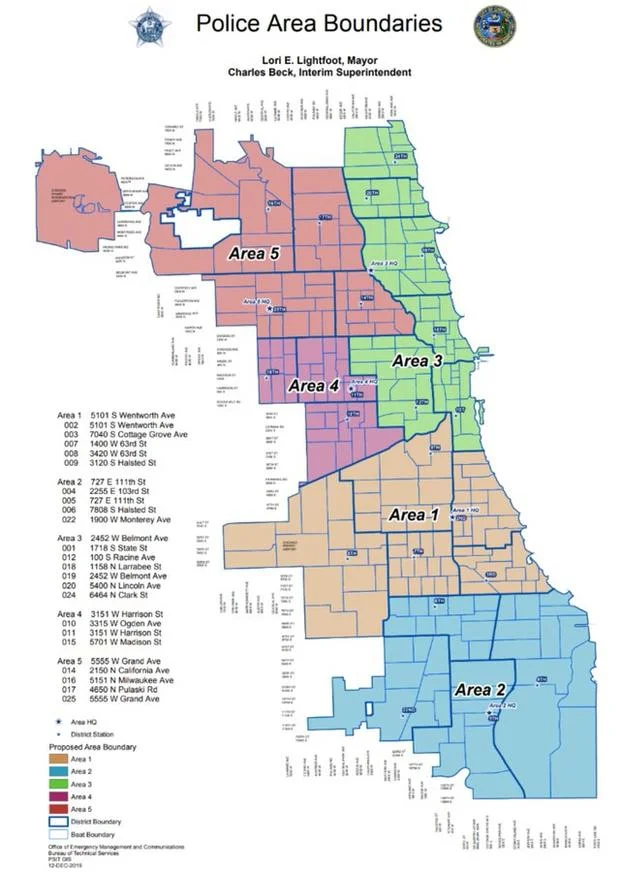

In [16]:
Image(filename="../imgs/2019-CPD-Area-Boundaries.webp")

Referring to [reporting](https://www.cbsnews.com/chicago/news/chicago-police-department-detective-areas-divisions-boundaries/) and [CPD public data](https://chicagopd.hub.arcgis.com/documents/ChicagoPD::area-district-beat-11x17-1/explore), we map each police district observed in the data to the corresponding police area.

- Area 1, now called Area Central, will include the 2nd, 3rd, 7th, 8th, and 9th districts on the South Side.
- Area 2, now called Area South, will include the 4th, 5th, 6th, and 22nd districts on the Far South Side.
- Area 3, now called Area **North**, will include the 1st, 12th, 18th, 19th, 20th, and 24th districts on the North Side, largely along the lakefront.
- Area 4 will include the 10th, 11th, and 15th districts on the West Side.
- Area 5 will include the 14th, 16th, 17th, and 25th districts on the Northwest Side.

In [17]:
%%jmd

### Events by police area

- The data refer to the police district associated with the call, but we map these to the
[reported](https://www.cbsnews.com/chicago/news/chicago-police-department-detective-areas-divisions-boundaries/)
corresponding police area to simplify analyses.
- Presented are the emergency event counts by police area.

{{ report_fields(df=data, idcol='event_no', cols=['area'], headn=10).to_html() }}

---


### Events by police area

- The data refer to the police district associated with the call, but we map these to the
[reported](https://www.cbsnews.com/chicago/news/chicago-police-department-detective-areas-divisions-boundaries/)
corresponding police area to simplify analyses.
- Presented are the emergency event counts by police area.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>area</th>
      <th>count</th>
      <th>percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>131,142</td>
      <td>34.5%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>104,839</td>
      <td>27.6%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>4</td>
      <td>69,066</td>
      <td>18.2%</td>
    </tr>
    <tr>
      <th>3</th>
      <td>5</td>
      <td>39,722</td>
      <td>10.4%</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>35,361</td>
      <td>9.3%</td>
    </tr>
  </tbody>
</table>

---

In [18]:
%%jmd

#### Source type by area

- Presented are the record counts by source type and police area.

{{ report_fields(df=data, idcol='event_no', cols=['area', 'source_type'], headn=10).sort_values(
    'area').reset_index(drop=True).to_html() }}

---


#### Source type by area

- Presented are the record counts by source type and police area.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>area</th>
      <th>source_type</th>
      <th>count</th>
      <th>percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>Human reporting gunfire</td>
      <td>68,615</td>
      <td>18.1%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>ShotSpotter alert</td>
      <td>62,527</td>
      <td>16.4%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>Human reporting gunfire</td>
      <td>53,770</td>
      <td>14.1%</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>ShotSpotter alert</td>
      <td>51,069</td>
      <td>13.4%</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>Human reporting gunfire</td>
      <td>34,925</td>
      <td>9.2%</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3</td>
      <td>ShotSpotter alert</td>
      <td>436</td>
      <td>0.1%</td>
    </tr>
    <tr>
      <th>6</th>
      <td>4</td>
      <td>Human reporting gunfire</td>
      <td>37,357</td>
      <td>9.8%</td>
    </tr>
    <tr>
      <th>7</th>
      <td>4</td>
      <td>ShotSpotter alert</td>
      <td>31,709</td>
      <td>8.3%</td>
    </tr>
    <tr>
      <th>8</th>
      <td>5</td>
      <td>Human reporting gunfire</td>
      <td>28,663</td>
      <td>7.5%</td>
    </tr>
    <tr>
      <th>9</th>
      <td>5</td>
      <td>ShotSpotter alert</td>
      <td>11,059</td>
      <td>2.9%</td>
    </tr>
  </tbody>
</table>

---

In [19]:
%%jmd

#### Area 1

- Presented are the record counts for Area 1, the area with the plurality of events, by source type and year occurred.

{{ report_fields(
    df=data.loc[data.area == '1'],
    idcol='event_no',
    cols=['source_type', 'year_occurred'], headn=10).sort_values(
    'year_occurred').reset_index(drop=True).to_html() }}

---


#### Area 1

- Presented are the record counts for Area 1, the area with the plurality of events, by source type and year occurred.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>source_type</th>
      <th>year_occurred</th>
      <th>count</th>
      <th>percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Human reporting gunfire</td>
      <td>2021</td>
      <td>20,928</td>
      <td>16.0%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>ShotSpotter alert</td>
      <td>2021</td>
      <td>16,985</td>
      <td>13.0%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Human reporting gunfire</td>
      <td>2022</td>
      <td>19,325</td>
      <td>14.7%</td>
    </tr>
    <tr>
      <th>3</th>
      <td>ShotSpotter alert</td>
      <td>2022</td>
      <td>15,265</td>
      <td>11.6%</td>
    </tr>
    <tr>
      <th>4</th>
      <td>ShotSpotter alert</td>
      <td>2023</td>
      <td>18,641</td>
      <td>14.2%</td>
    </tr>
    <tr>
      <th>5</th>
      <td>Human reporting gunfire</td>
      <td>2023</td>
      <td>17,089</td>
      <td>13.0%</td>
    </tr>
    <tr>
      <th>6</th>
      <td>ShotSpotter alert</td>
      <td>2024</td>
      <td>11,636</td>
      <td>8.9%</td>
    </tr>
    <tr>
      <th>7</th>
      <td>Human reporting gunfire</td>
      <td>2024</td>
      <td>11,273</td>
      <td>8.6%</td>
    </tr>
  </tbody>
</table>

---